In [1]:
# from duckduckgo_search import images
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=30):
    ddgs = DDGS()
    print(f"Searching for '{term}'")
    return L(ddgs.images(term, max_results=max_images)).itemgot('image')

## Testing the model on a test set

Download some more images

In [8]:
searches = 'fast sports car','slow sedan car'
path = Path('sports_car_or_not_testset')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}', max_images=200), max_pics=300)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Delete failed images

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Load the model

In [10]:
path = Path('sports_car_or_not')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

learn = vision_learner(dls, resnet50, metrics=error_rate)

In [11]:
loaded_model = learn.load('model', device='cpu')

## Test the model

In [12]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to the test set
test_set_path = "sports_car_or_not_testset"

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Iterate through the subfolders
for folder in os.listdir(test_set_path):
    folder_path = os.path.join(test_set_path, folder)
    if os.path.isdir(folder_path):
        # Determine the true label based on the folder name
        true_label = "sports car" if "fast sports car" in folder.lower() else "sedan car"
        
        # Iterate through images in the folder
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            
            # Make prediction
            pred, _, _ = loaded_model.predict(image_path)
            
            # Store true label and prediction
            true_labels.append(true_label)
            predictions.append(pred)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, pos_label="sports car")
recall = recall_score(true_labels, predictions, pos_label="sports car")
f1 = f1_score(true_labels, predictions, pos_label="sports car")



Accuracy: 0.8091
Precision: 0.7487
Recall: 0.9211
F1-score: 0.8260


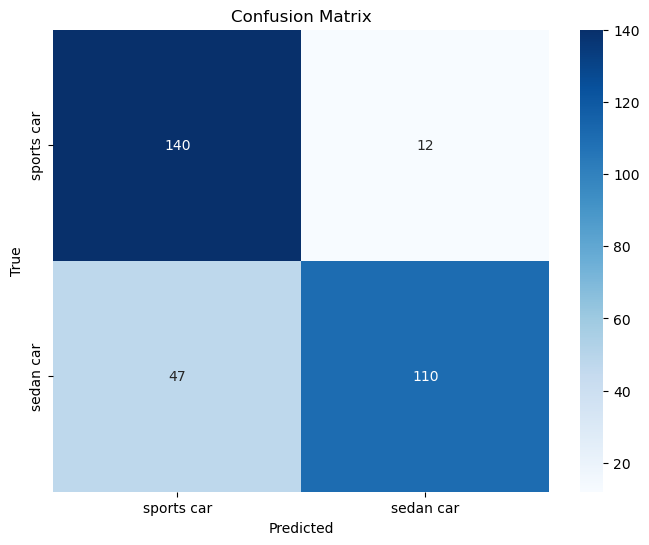

sports car accuracy: 0.9211
sedan car accuracy: 0.7006


In [14]:
# Print summary statistics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=["sports car", "sedan car"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["sports car", "sedan car"], 
            yticklabels=["sports car", "sedan car"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate class-wise accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(["sports car", "sedan car"]):
    print(f"{class_name} accuracy: {class_accuracy[i]:.4f}")

## Conclusion

The model is okay 